In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Import Bagging Classifier.
import timeit
pd.set_option('display.max_rows',None)

In [4]:
starwars_df = pd.read_csv('./data/starwar_0820.csv')
marvel_df = pd.read_csv('./data/marvel_0820.csv')

In [5]:
starwars_df['subreddit'].value_counts()

StarWars    20000
Name: subreddit, dtype: int64

In [6]:
marvel_df['subreddit'].value_counts()

marvelstudios    20000
Name: subreddit, dtype: int64

In [7]:
print(starwars_df.shape)
print(marvel_df.shape)

(20000, 87)
(20000, 84)


In [9]:
#check all the features
starwars_df.head(2).T

,0,1
Unnamed: 0,0,1
all_awardings,[],[]
allow_live_comments,False,False
author,ReverendPalpatine,LifeAccordingToLevi
author_flair_css_class,2-13 bigFlair,7-14 bigFlair
author_flair_richtext,[],[]
author_flair_template_id,887385a0-77ee-11e9-8a98-0e4259a38b44,c4e08714-77f2-11e9-a251-0ecca1af61f4
author_flair_text,Darth Sidious,Sabine Wren
author_flair_text_color,dark,dark
author_flair_type,text,text


In [10]:
#define a function to check whether each row in the dataframe is unique.
def uniq_title(df = starwars_df, col = 'title'):
    if len(set(df[col])) == len(df.index):
        return ("The input dataframe has no duplicated rows")
    else:
        return ("Warning: the input dataframe has duplicated rows")

In [11]:
uniq_title()

'Warning: the input dataframe has duplicated rows'

In [12]:
uniq_title(df = marvel_df)

'Warning: the input dataframe has duplicated rows'

In [15]:
# Drop the duplicated titles
starwars_df.drop_duplicates('title',inplace = True)
marvel_df.drop_duplicates('title',inplace = True)

In [16]:
len(set(marvel_df['title']))

19184

In [17]:
len(set(starwars_df['title']))

19044

In [18]:
print(starwars_df.shape)
print(marvel_df.shape)

(19044, 87)
(19184, 84)


In [19]:
uniq_title()

'The input dataframe has no duplicated rows'

In [20]:
uniq_title(df = marvel_df)

'The input dataframe has no duplicated rows'

**Comments**
- The datasets have no duplicated titles
- 19,044 posts from 'StarWars' and 19184 posts from 'marvelstudios' were kept

### Number of posts to use
The maximum number of posts obtained for this tests was about 20k from each subreddit. First let's investigate how the number of posts will impact on building the models and their predictions. We will compare the following cases with CountVectorizer and Multinomial Naive Bayes model:
* 200 posts from each subreddit
* 500 posts from each subreddit
* 2000 posts from each subreddit
* 5000 posts from each subreddit
* 10000 posts from each subreddit
* maximum number of posts from each subreddit

In [21]:
# define a function randomly sample a subset from a dataframe.
def get_subset(df = starwars_df,sample_num = 200):
    return df.sample(n=sample_num, replace = False)

In [22]:
numlist = [200,500,2000,5000,10000]
starwars_test = [get_subset(sample_num = n) for n in numlist]

In [23]:
marvel_test = [get_subset(df = marvel_df,sample_num = n) for n in numlist]

In [334]:
## save the sampled testing data
# for i,n in enumerate(numlist):
#     starwars_test[i].to_csv('./data/starwars_'+str(n)+'.csv')
#     marvel_test[i].to_csv('./data/marvel_'+str(n)+'.csv')
#     starcraft_df[i].to_csv('./data/starcraft_'+str(n)+'.csv')

In [2]:
# define a function that combines the dataframe from two subreddit,and only keep the select columns for building models
def combine_subreddit(df1,df2,col = ['subreddit','title'],subreddits = ('StarWars','marvelstudios')):
    data = pd.concat([df1[col],df2[col]])
    data.reset_index(inplace = True,drop=True)
    data['subreddit'] = data['subreddit'].map({subreddits[0]:1,subreddits[1]:0})
    return data     

In [25]:
data_max = combine_subreddit(starwars_df,marvel_df)
data_10000 = combine_subreddit(starwars_test[4],marvel_test[4])
data_5000 = combine_subreddit(starwars_test[3],marvel_test[3])
data_2000 = combine_subreddit(starwars_test[2],marvel_test[2])
data_500 = combine_subreddit(starwars_test[1],marvel_test[1])
data_200 = combine_subreddit(starwars_test[0],marvel_test[0])

In [26]:
print(data_200['subreddit'].value_counts())
print(data_500['subreddit'].value_counts())
print(data_2000['subreddit'].value_counts())
print(data_5000['subreddit'].value_counts())
print(data_10000['subreddit'].value_counts())
print(data_max['subreddit'].value_counts())

1    200
0    200
Name: subreddit, dtype: int64
1    500
0    500
Name: subreddit, dtype: int64
1    2000
0    2000
Name: subreddit, dtype: int64
1    5000
0    5000
Name: subreddit, dtype: int64
1    10000
0    10000
Name: subreddit, dtype: int64
0    19184
1    19044
Name: subreddit, dtype: int64


Now we have 6 sets of datasets for testing on the number of posts

#### Function to Run GridSearchCV for user provided vectorizer and model in a pipeline

In [3]:
#define a function that run GridSearchCV for user provided vectorizer and model
def pipe_gridsearch_cv(X = None, y = None, pipelist = None,pipe_params = None,cv = 5):
#     input: X -> the training matrix
#            y -> the training target
#            pipelist -> the list provoding the things in the Pipeline
#            pipe_params -> the parameters for the pipe line
#            cv -> the number of folds for cross validation in GridSearchCV
#      output: The best estimator from GridSearchCV with the provided parameters

    pipe = Pipeline(pipelist)
    pipe_params = pipe_params
    gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = cv)
    gs.fit(X,y)
    return gs

In [5]:
pipelist = [('cvec',CountVectorizer()),('nb',MultinomialNB())]
pipe_params = {
    'cvec__max_features' : [2000,3000,4000,5000],
    'cvec__min_df' : [2,3],
    'cvec__max_df' : [0.9,0.95],
    'cvec__ngram_range' : [(1,1),(1,2)],
    'cvec__stop_words' : [None,'english']
}

In [272]:
# Evaluating the models built from different number of posts
gs_list = []
train_scores=[]
test_scores=[]
for data in [data_200,data_500,data_2000,data_5000,data_10000,data_max]:
    X = data['title']
    y = data['subreddit']
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.33,
                                                        stratify=y,
                                                        random_state=42)
    gs = pipe_gridsearch_cv(X = X_train, y = y_train, pipelist=pipelist,pipe_params = pipe_params)
    train_scores.append(gs.best_estimator_.score(X_train,y_train))
    test_scores.append(gs.best_estimator_.score(X_test,y_test))
    gs_list.append(gs)

In [273]:
train_scores

[0.9216417910447762,
 0.9238805970149254,
 0.9388059701492537,
 0.9328358208955224,
 0.9283582089552239,
 0.9229657972825238]

In [274]:
test_scores

[0.7045454545454546,
 0.8272727272727273,
 0.878030303030303,
 0.8978787878787878,
 0.9018181818181819,
 0.904565630944832]

In [275]:
for gs in gs_list:
    print(gs.best_score_)
    print(gs.best_estimator_)

0.7278825995807128
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=2000, min_df=2)),
                ('nb', MultinomialNB())])
0.8104477611940297
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=2000, min_df=2)),
                ('nb', MultinomialNB())])
0.8783582089552239
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=2000, min_df=2)),
                ('nb', MultinomialNB())])
0.8898507462686567
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=4000, min_df=2)),
                ('nb', MultinomialNB())])
0.9002985074626866
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=5000, min_df=2)),
                ('nb', MultinomialNB())])
0.9069187636618681
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=5000, min_df=2)),
                ('nb', MultinomialNB())])


In [279]:
row_num_scan = pd.DataFrame([train_scores,test_scores],index = ['train','test'],columns= [400,1000,4000,10000,20000,38228]
)

In [285]:
row_num_scan.T

,train,test
400,0.921642,0.704545
1000,0.923881,0.827273
4000,0.938806,0.878030
10000,0.932836,0.897879
20000,0.928358,0.901818
38228,0.922966,0.904566


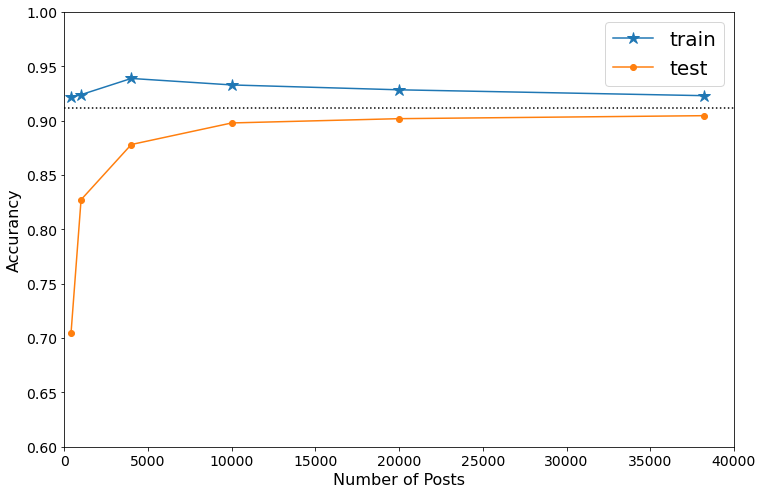

In [329]:
# Plot the scores vs number of posts
plt.figure(figsize = (12,8))
plt.plot(row_num_scan.T.index,row_num_scan.T['train'],'-*',label = 'train',markersize = 12)
plt.plot(row_num_scan.T.index,row_num_scan.T['test'],'-o',label = 'test')
plt.xlim(0,40000)
plt.ylim(0.6,1)
plt.hlines(0.912,0,40000,linestyle = 'dotted')
plt.xlabel("Number of Posts",fontsize = 16)
plt.ylabel("Accurancy",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 20)
plt.savefig('./image/numberofpost.jpeg');

**Comments**   
* Increasing number of posts will reduce the variance of the model  
* Using 20k, and ~40k posts gave similar scores from the MultinomialNB models
* In order to compromise the model performance and computation costs, I will using 20k posts for the rest of this project